<a href="https://colab.research.google.com/github/zuzann18/Praca-Magisterska/blob/main/HuggingFace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load and Explore the Dataset

In [25]:
# Install the Hugging Face 'datasets' library
!pip install datasets

# Import necessary library
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("pittawat/letter_recognition")

# Explore the dataset
print(dataset)

# Example: Accessing specific data
train_data = dataset['train']


first_entry = train_data[0]
print(type(first_entry))  # To check the type of the entry
print(first_entry)        # To see the actual content

# To check the type of the image and label
print(type(first_entry['image']))
print(type(first_entry['label']))


DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 26000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 2600
    })
})
<class 'dict'>
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=28x28 at 0x7F014FE14040>, 'label': 0}
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'int'>


Visualize the Data

In [26]:

def show_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(10, 2))
    for i in range(num_images):
        # Assuming the image is stored as a PIL Image object
        ax = axes[i]
        ax.imshow(np.array(dataset[i]['image']), cmap='gray')
        ax.set_title(f"Label: {dataset[i]['label']}")
        ax.axis('off')

    plt.show()
def plot_label_distribution(dataset):
    labels = [sample['label'] for sample in dataset]
    sns.countplot(labels)
    plt.title("Distribution of Labels")
    plt.xlabel("Label")
    plt.ylabel("Count")
    plt.show()

#---------"Preprocess the Data"

# Converting images from PIL to numpy array,  normalization
def preprocess_image(image):
    image_array = np.array(image)
    return image_array / 255.0

# Preprocessing data
def preprocess_data(dataset):
    images = np.array([preprocess_image(sample['image']) for sample in dataset])
    labels = to_categorical([sample['label'] for sample in dataset])
    return images, labels

X, y = preprocess_data(train_data)

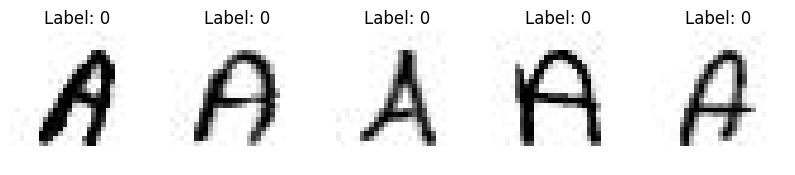

In [27]:
import matplotlib.pyplot as plt

def show_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(10, 2))
    for i, ax in enumerate(axes):
        ax.imshow(np.squeeze(dataset[i]['image']), cmap='gray')
        ax.title.set_text(f"Label: {dataset[i]['label']}")
        ax.axis('off')
    plt.show()

show_images(train_data)


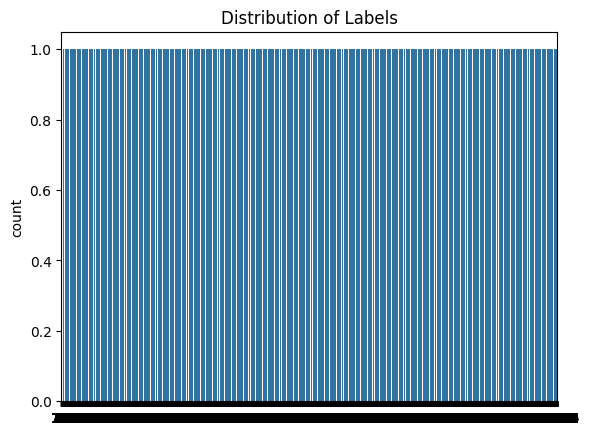

In [28]:
import seaborn as sns

labels = [sample['label'] for sample in train_data]
sns.countplot(labels)
plt.title("Distribution of Labels")
plt.show()


In [29]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, Flatten, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import numpy as np
from datasets import load_dataset
from PIL import Image
import keras_tuner as kt
from sklearn.model_selection import train_test_split

# Dynamic learning rate schedule function
def lr_schedule(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * np.exp(-0.1)

# Function to create a neural network model based on configuration
def create_model(config):
    model = Sequential()

    for layer_config in config.get('layers', []):
        layer_type = layer_config['type']

        if layer_type == 'Conv2D':
            model.add(Conv2D(layer_config['filters'], layer_config['kernel_size'],
                             activation=layer_config['activation'],
                             input_shape=layer_config.get('input_shape')))
        elif layer_type == 'MaxPooling2D':
            model.add(MaxPooling2D(pool_size=layer_config['pool_size']))
        elif layer_type == 'Flatten':
            model.add(Flatten())
        elif layer_type == 'Dense':
            model.add(Dense(units=layer_config['units'], activation=layer_config['activation']))
        elif layer_type == 'Dropout':
            model.add(Dropout(rate=layer_config['rate']))
        elif layer_type == 'BatchNormalization':
            model.add(BatchNormalization())

    model.add(Dense(config['output_units'], activation=config['output_activation']))

    optimizer = Adam(learning_rate=config.get('learning_rate', 0.001))
    model.compile(optimizer=optimizer, loss=config['loss'], metrics=config['metrics'])
    return model



# Example configuration for CNN
config = [
    {
        'experiment_id': 5,
        'layers': [
            {'type': 'Conv2D', 'filters': 32, 'kernel_size': (3, 3), 'activation': 'relu', 'input_shape': (28, 28, 3)},
            {'type': 'MaxPooling2D', 'pool_size': (2, 2)},
            {'type': 'Flatten'},
            {'type': 'Dense', 'units': 64, 'activation': 'relu'},
            {'type': 'Dropout', 'rate': 0.5},
            {'type': 'BatchNormalization'}
        ],
        'output_units': 26,
        'output_activation': 'softmax',
        'loss': 'categorical_crossentropy',
        'metrics': ['accuracy'],
        'learning_rate': 0.001
    },
    # Add more configurations as needed
]

# Load and preprocess data
dataset = load_dataset("pittawat/letter_recognition")
train_images, train_labels = preprocess_data(dataset['train'])
test_images, test_labels = preprocess_data(dataset['test'])


# Sprawdzenie wymiarów danych
print("Wymiary obrazów treningowych:", train_images.shape)
print("Wymiary etykiet treningowych:", train_labels.shape)
print("Wymiary obrazów testowych:", test_images.shape)
print("Wymiary etykiet testowych:", test_labels.shape)


# Experiments
for cfg in config:
    model = create_model(cfg)
    checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)
    history = model.fit(train_images, train_labels, epochs=20, callbacks=[LearningRateScheduler(lr_schedule), checkpoint])
    evaluation = model.evaluate(test_images, test_labels)
    print(f"Experiment {cfg['experiment_id']} - Accuracy: {evaluation[1]}")


Wymiary obrazów treningowych: (26000, 28, 28, 3)
Wymiary etykiet treningowych: (26000, 26)
Wymiary obrazów testowych: (2600, 28, 28, 3)
Wymiary etykiet testowych: (2600, 26)
Epoch 1/20
812/813 [============================>.] - ETA: 0s - loss: 1.6851 - accuracy: 0.5429

813/813 [==============================] - 21s 24ms/step - loss: 1.6846 - accuracy: 0.5431 - lr: 0.0010
Epoch 2/20
812/813 [============================>.] - ETA: 0s - loss: 0.7939 - accuracy: 0.7740

813/813 [==============================] - 17s 21ms/step - loss: 0.7938 - accuracy: 0.7740 - lr: 0.0010
Epoch 3/20
811/813 [============================>.] - ETA: 0s - loss: 0.6350 - accuracy: 0.8149

813/813 [==============================] - 17s 21ms/step - loss: 0.6348 - accuracy: 0.8150 - lr: 0.0010
Epoch 4/20
812/813 [============================>.] - ETA: 0s - loss: 0.5472 - accuracy: 0.8401

813/813 [==============================] - 18s 22ms/step - loss: 0.5471 - accuracy: 0.8401 - lr: 0.0010
Epoch 5/20
812/813 [============================>.] - ETA: 0s - loss: 0.5018 - accuracy: 0.8503

813/813 [==============================] - 17s 21ms/step - loss: 0.5020 - accuracy: 0.8502 - lr: 0.0010
Epoch 6/20
812/813 [============================>.] - ETA: 0s - loss: 0.4522 - accuracy: 0.8616

813/813 [==============================] - 17s 21ms/step - loss: 0.4522 - accuracy: 0.8615 - lr: 0.0010
Epoch 7/20
813/813 [==============================] - ETA: 0s - loss: 0.4259 - accuracy: 0.8682

813/813 [==============================] - 17s 21ms/step - loss: 0.4259 - accuracy: 0.8682 - lr: 0.0010
Epoch 8/20
812/813 [============================>.] - ETA: 0s - loss: 0.4001 - accuracy: 0.8750

813/813 [==============================] - 17s 21ms/step - loss: 0.4000 - accuracy: 0.8751 - lr: 0.0010
Epoch 9/20
812/813 [============================>.] - ETA: 0s - loss: 0.3820 - accuracy: 0.8802

813/813 [==============================] - 18s 22ms/step - loss: 0.3821 - accuracy: 0.8802 - lr: 0.0010
Epoch 10/20
811/813 [============================>.] - ETA: 0s - loss: 0.3589 - accuracy: 0.8850

813/813 [==============================] - 18s 22ms/step - loss: 0.3588 - accuracy: 0.8850 - lr: 0.0010
Epoch 11/20
812/813 [============================>.] - ETA: 0s - loss: 0.3296 - accuracy: 0.8950

813/813 [==============================] - 19s 23ms/step - loss: 0.3299 - accuracy: 0.8950 - lr: 9.0484e-04
Epoch 12/20
811/813 [============================>.] - ETA: 0s - loss: 0.3163 - accuracy: 0.8987

813/813 [==============================] - 19s 23ms/step - loss: 0.3163 - accuracy: 0.8987 - lr: 8.1873e-04
Epoch 13/20
813/813 [==============================] - ETA: 0s - loss: 0.2991 - accuracy: 0.9038

813/813 [==============================] - 18s 23ms/step - loss: 0.2991 - accuracy: 0.9038 - lr: 7.4082e-04
Epoch 14/20
812/813 [============================>.] - ETA: 0s - loss: 0.2899 - accuracy: 0.9071

813/813 [==============================] - 18s 22ms/step - loss: 0.2898 - accuracy: 0.9071 - lr: 6.7032e-04
Epoch 15/20
811/813 [============================>.] - ETA: 0s - loss: 0.2760 - accuracy: 0.9104

813/813 [==============================] - 18s 22ms/step - loss: 0.2760 - accuracy: 0.9104 - lr: 6.0653e-04
Epoch 16/20
813/813 [==============================] - ETA: 0s - loss: 0.2570 - accuracy: 0.9157

813/813 [==============================] - 19s 23ms/step - loss: 0.2570 - accuracy: 0.9157 - lr: 5.4881e-04
Epoch 17/20
813/813 [==============================] - ETA: 0s - loss: 0.2323 - accuracy: 0.9242

813/813 [==============================] - 18s 22ms/step - loss: 0.2323 - accuracy: 0.9242 - lr: 4.9659e-04
Epoch 18/20
811/813 [============================>.] - ETA: 0s - loss: 0.2435 - accuracy: 0.9204

813/813 [==============================] - 19s 23ms/step - loss: 0.2435 - accuracy: 0.9204 - lr: 4.4933e-04
Epoch 19/20
813/813 [==============================] - ETA: 0s - loss: 0.2247 - accuracy: 0.9263

813/813 [==============================] - 18s 22ms/step - loss: 0.2247 - accuracy: 0.9263 - lr: 4.0657e-04
Epoch 20/20
811/813 [============================>.] - ETA: 0s - loss: 0.2211 - accuracy: 0.9274

82/82 [==============================] - 1s 8ms/step - loss: 0.1478 - accuracy: 0.9600
Experiment 5 - Accuracy: 0.9599999785423279
